# Import library
run two cells below first

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import time
from datetime import datetime
import sys
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
if 'holidays' not in sys.modules:
    !pip install holidays
import holidays

You should consider upgrading via the 'pip install --upgrade pip' command.


# Load three csv files
Summary: 937 unique drivers and 193502 unique rides in total

In [2]:
driver_df = pd.read_csv('driver_ids.csv')
ride_df = pd.read_csv('ride_ids.csv')
ride_timestamps_df = pd.read_csv('ride_timestamps.csv')

In [3]:
'''
Get the shape of each dataframe
'''
print('driver ids:',driver_df.shape)
display(driver_df.head())
print('ride ids:',ride_df.shape)
display(ride_df.head())
print('ride timestamps:',ride_timestamps_df.shape)
display(ride_timestamps_df.head())

driver ids: (937, 2)


,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


ride ids: (193502, 5)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


ride timestamps: (970405, 3)


,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


# Inspect Nan and abnormal values

In [4]:
'''
Nan value inspection
'''
print('driver ids info:------------------------------')
driver_df.info()
print('ride ids info:--------------------------------')
ride_df.info()
print('ride timestamps info:-------------------------')
ride_timestamps_df.info()
'''
ride_timestamps has one Nan value in the column timestamp
    TODO: delete this ride or fill it with an artificial value?
'''
display(ride_timestamps_df[ride_timestamps_df.isnull().any(axis=1)])

driver ids info:------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 2 columns):
driver_id              937 non-null object
driver_onboard_date    937 non-null object
dtypes: object(2)
memory usage: 14.7+ KB
ride ids info:--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 5 columns):
driver_id          193502 non-null object
ride_id            193502 non-null object
ride_distance      193502 non-null int64
ride_duration      193502 non-null int64
ride_prime_time    193502 non-null int64
dtypes: int64(3), object(2)
memory usage: 7.4+ MB
ride timestamps info:-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970405 entries, 0 to 970404
Data columns (total 3 columns):
ride_id      970405 non-null object
event        970405 non-null object
timestamp    970404 non-null object
dtypes: object(3)
memory usage: 22.2+ MB


,ride_id,event,timestamp
434222,72f0fa0bd86800e9da5c4dced32c8735,arrived_at,NaN


In [5]:
'''
Abnormal value inspection
'''
display(driver_df.describe())
display(ride_df.describe())
display(ride_timestamps_df.describe())

,driver_id,driver_onboard_date
count,937,937
unique,937,49
top,9494350df132e6748afca3bc5d138dcc,2016-04-05 00:00:00
freq,1,36


,ride_distance,ride_duration,ride_prime_time
count,193502.000000,193502.000000,193502.000000
mean,6955.218266,858.966099,17.305893
std,8929.444606,571.375818,30.825800
min,-2.000000,2.000000,0.000000
25%,2459.000000,491.000000,0.000000
50%,4015.000000,727.000000,0.000000
75%,7193.000000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


,ride_id,event,timestamp
count,970405,970405,970404
unique,194081,5,865826
top,43b8fb03256e30a1a93db73d09a05b26,requested_at,2016-04-30 22:09:15
freq,5,194081,7


In [6]:
'''
TODO: Need to think about how to deal with this case, why will ride_distance <= 0?
TODO: the number of ride_id in ride_df and that of ride_timestamps doesn't fit (193502 vs 194081)
'''
abnormal_ride_df = ride_df[ride_df.ride_distance <= 0]
print(abnormal_ride_df.shape)
display(abnormal_ride_df.head())

(187, 5)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
3557,04d686ef2fba281e395992a28f14fdd3,c819e844b0c043786f1291e466478ca0,0,127,0
4221,0656192a402808805282e60761bda088,2f4fe99f74f1d71fdf2e8e18da9670c0,0,404,25
5120,07dd442e3e0b9f0f9b0d69c7b47cbb06,ad2b44316299477f2d6537922af22bf4,0,7,0
7144,0b631e16fa61f7321da18cf35a076d5f,1410283d27fdcf6c25a11f856ce5cde0,0,66,0
7713,0c02bd2b09f7193103279ab9b760b777,9fd795fdb616bd47c41e1ad07abbd6f3,0,23,50


In [7]:
'''
find overlap of driver_id between dirver_df and ride_df
TODO: some drivers don't have ride information--->delete? (937 vs 854)
'''
print(len(set(driver_df.driver_id.unique()).intersection(set(ride_df.driver_id.unique()))))

854


In [8]:
'''
find overlap of ride_id between ride_df and ride_timestamps_df
TODO: some rides don't have ride timestamps--->delete? (193502 vs 184819)
'''
print(len(set(ride_df.ride_id.unique()).intersection(set(ride_timestamps_df.ride_id.unique()))))

184819


# Merge all dfs to one df

In [9]:
'''
merge driver_df and ride_df (Get intersection based on driver_id)
'''
big_df = ride_df.merge(driver_df,left_on='driver_id',right_on='driver_id')
print(big_df.shape)
display(big_df.head())

(185891, 6)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,2016-03-29 00:00:00
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,2016-03-29 00:00:00
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,2016-03-29 00:00:00
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,2016-03-29 00:00:00
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,2016-03-29 00:00:00


In [10]:
# get overlapped ride_id between big_df and ride_timestamps_df
big_df = big_df[big_df['ride_id'].isin(ride_timestamps_df.ride_id.unique())]
big_df.reset_index(drop=True,inplace=True)
print(big_df.shape)
display(big_df.head())

(184209, 6)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,2016-03-29 00:00:00
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,2016-03-29 00:00:00
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,2016-03-29 00:00:00
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,2016-03-29 00:00:00
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,2016-03-29 00:00:00


In [11]:
start = time.time()
# for each unique ride id in big_df
for idx in range(big_df.shape[0]):
    rideid = big_df.iloc[idx]['ride_id']
    # first find rideid timestamps info in ride_timestamps_df
    target = ride_timestamps_df[ride_timestamps_df.ride_id == rideid]
    # for each (event,timestamp) pair
    for (e,t) in zip(list(target.event),list(target.timestamp)):
        big_df.at[idx,e] = t
    # double check index
    if big_df[big_df.ride_id == rideid]['requested_at'].values[0] != \
    ride_timestamps_df[ride_timestamps_df.ride_id == rideid].iloc[0,-1]:
        print(idx)
print('duration:',(time.time()-start)/3600,'hrs')

duration: 7.626359305050638 hrs


In [12]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184209 entries, 0 to 184208
Data columns (total 11 columns):
driver_id              184209 non-null object
ride_id                184209 non-null object
ride_distance          184209 non-null int64
ride_duration          184209 non-null int64
ride_prime_time        184209 non-null int64
driver_onboard_date    184209 non-null object
requested_at           184209 non-null object
accepted_at            184209 non-null object
arrived_at             184208 non-null object
picked_up_at           184209 non-null object
dropped_off_at         184209 non-null object
dtypes: int64(3), object(8)
memory usage: 15.5+ MB


In [13]:
# saved for future use
big_df.to_csv('merged_big_driver_ride_df.csv',index=False)

# Start to work on calculating featuredvariables
If already have file 'merged_big_driver_ride_df.csv', directly start running code below

In [26]:
def get_fare(driver_rides):
    total_fare = 0
    # if one single ride
    if driver_rides.ndim == 1:
        total_fare = (1 + driver_rides['ride_prime_time']/100)*(min(max(5,(2 + 1.15*driver_rides['ride_distance']\
                                                                            *0.00062 + 0.22\
                                                                            *driver_rides['ride_duration']/60 \
                                                                            + 1.75)),400))
    else:
        for (distance,duration,prime) in zip(driver_rides['ride_distance'].values,\
                                             driver_rides['ride_duration'].values,\
                                             driver_rides['ride_prime_time'].values):
            total_fare += (1 + prime/100)*(min(max(5,(2 + 1.15*distance*0.00062 + 0.22*duration/60 + 1.75)),400))
    return total_fare

In [27]:
merged_big_df = pd.read_csv('merged_big_driver_ride_df.csv')
print(merged_big_df.shape)
display(merged_big_df.head())

(184209, 11)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,2016-03-29 00:00:00,2016-04-23 02:13:50,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:16:40,2016-04-23 02:22:07
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,2016-03-29 00:00:00,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:04:01,2016-03-29 19:17:30
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,2016-03-29 00:00:00,2016-06-21 11:56:31,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:01:35,2016-06-21 12:11:07
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,2016-03-29 00:00:00,2016-05-19 09:15:29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 09:18:20,2016-05-19 10:13:58
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,2016-03-29 00:00:00,2016-04-20 22:05:30,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:07:02,2016-04-20 22:20:45


In [19]:
# '''
# validate the correctness of combined df by randomly selecting ride ids to verify (random checking)
# '''
# ids = test1.ride_id
# i = np.random.choice(ids,10)
# for x in i:
#     display(test1[test1.ride_id == x])
#     display(ride_timestamps_df[ride_timestamps_df.ride_id == x])

## Get new variables related to ride info
time of day: 0-6(midnight); 6-9(morning rush); 9-16(normal day); 16-19(evening rush); 19-24(fun) <br>
season: {0: Spring, 1: Summer, 2: Autumn, 3: Winter}

In [28]:
# variables related to ride
def add_vars(row):
    # convert time to datetime
    # source: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    for i in range(5,len(row)):
        if type(row[i]) != float:
            row[i] = datetime.strptime(row[i], '%Y-%m-%d %H:%M:%S')
    # get speed
    row['speed(m/s)'] = row['ride_distance'] / row['ride_duration']
    # holiday? reference: https://stackoverflow.com/questions/2394235/detecting-a-us-holiday
    row['holiday'] = int(row['requested_at'] in holidays.US())
    # requested_at time is weekend? (0-6 --> Mon-Sun)
    row['weekend'] = int(row['requested_at'].weekday() > 4)
    # time of day (6-12/12-15/16-20/20-24/24-6)
    # {0: [6,9), 1: [9,16), 2: [16,19), 3: [19,24), 4: [0,6)}
    if 6 <= row['requested_at'].hour < 9:
        row['time of day'] = 0
    elif 9 <= row['requested_at'].hour < 16:
        row['time of day'] = 1
    elif 16 <= row['requested_at'].hour < 19:
        row['time of day'] = 2
    elif 19 <= row['requested_at'].hour < 24:
        row['time of day'] = 3
    else:
        row['time of day'] = 4
    # season (12-2 Winter/3-5 Spring/6-8 Summer/9-11 Autumn)
    # {0: Spring, 1: Summer, 2: Autumn, 3: Winter}
    if 3 <= row['requested_at'].month <= 5:
        row['season'] = 0
    elif 6 <= row['requested_at'].month <= 8:
        row['season'] = 1
    elif 9 <= row['requested_at'].month <= 11:
        row['season'] = 2
    else:
        row['season'] = 3
    # time spent from requested_at to arrived_at (efficiency of picking up a customer)
    if type(row['arrived_at']) != float:
        row['time spent to arrive at the customer(minutes)'] = (row['arrived_at']-\
                                                                row['requested_at']).total_seconds()/60
    else:
        row['time spent to arrive at the customer(minutes)'] = (row['picked_up_at']-\
                                                                row['requested_at']).total_seconds()/60
    # fare for this ride
    row['fare'] = get_fare(row)
    return row

start = time.time()
rides_added_vars_df = merged_big_df.apply(add_vars,axis=1)
print('duration:',(time.time() - start)/60,'minutes')

duration: 18.182074280579887 minutes


In [29]:
print(rides_added_vars_df.shape)
display(rides_added_vars_df.head())

(184209, 18)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,speed(m/s),holiday,weekend,time of day,season,time spent to arrive at the customer(minutes),fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,2016-03-29,2016-04-23 02:13:50,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:16:40,2016-04-23 02:22:07,5.538226,0,1,4,0,2.766667,9.360364
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,2016-03-29,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:04:01,2016-03-29 19:17:30,4.155748,0,0,3,0,3.133333,9.113439
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,2016-03-29,2016-06-21 11:56:31,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:01:35,2016-06-21 12:11:07,5.737762,0,0,1,1,5.016667,8.187399
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,2016-03-29,2016-05-19 09:15:29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 09:18:20,2016-05-19 10:13:58,19.557519,0,0,1,0,2.850000,78.170140
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,2016-03-29,2016-04-20 22:05:30,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:07:02,2016-04-20 22:20:45,5.000000,0,0,3,0,1.550000,19.403323


In [30]:
# saved for future use
rides_added_vars_df.to_csv('added_variables_rides_info.csv',index=False)

## Get new variables related to drivers

In [85]:
drivers_df = pd.DataFrame(rides_added_vars_df.driver_id.unique())
drivers_df.rename(columns={0:'driver_id'},inplace=True)
drivers_df.reset_index(drop=True,inplace=True)
print(drivers_df.shape)
display(drivers_df.head())

(837, 1)


,driver_id
0,002be0ffdc997bd5c50703158b7c2491
1,007f0389f9c7b03ef97098422f902e62
2,011e5c5dfc5c2c92501b8b24d47509bc
3,0152a2f305e71d26cc964f8d4411add9
4,01674381af7edd264113d4e6ed55ecda


In [24]:
def add_driver_vars(row):
    # first find all rides under driverid
    rides = rides_added_vars_df[rides_added_vars_df.driver_id == row['driver_id']]
    # Percentage of rides completed in prime time among all rides for each driver
    row['prime time rides percentage'] = rides[rides.ride_prime_time != 0].shape[0] / rides.shape[0]
    # Average active time per day for each driver (total duration / total days)
    sorted_days = rides.groupby('requested_at', as_index=False).mean()['requested_at']
    days = len(sorted_days.dt.normalize().unique())
    row['average daily active time(hrs/day)'] = rides.ride_duration.sum() / (3600*days)
    # Average fare(daily/per ride/monthly) received for each driver
    total_fare = get_fare(rides)
    row['gross fare(over all rides)'] = total_fare
    row['average daily fare'] = total_fare / days
    row['average fare per ride'] = total_fare / rides.shape[0]
    number_of_months = len(set([(x.year,x.month) for x in sorted_days]))
    row['average monthly fare'] = total_fare / number_of_months
    # Total number of rides
    row['total rides'] = rides.shape[0]
    # Number of abnormal rides (ride_distance <= 0)
    row['number of abnormal rides'] = rides[rides.ride_distance <= 0].shape[0]
    # Ride completion rate (1 - (# of abnormal / total rides))
    row['completion rate'] = 1 - (row['number of abnormal rides'] / row['total rides'])
    # Unique days of work
    row['active days'] = days
    # Average time spent on each ride (requested_at --> arrived_at) in minutes
    row['average arriving time(minutes)'] = rides['time spent to arrive at the customer(minutes)'].mean()
    return row

start = time.time()
drivers_added_vars_df = drivers_df.apply(add_driver_vars,axis=1)
print('duration:',(time.time() - start)/60,'minutes')

duration: 0.41034599939982097 minutes


In [26]:
# saved for future use
drivers_added_vars_df.to_csv('added_variables_drivers_info.csv',index=False)

In [610]:
'''
rides info combined dataframe
'''
big_rides_info = pd.read_csv('added_variables_rides_info.csv', parse_dates = ['driver_onboard_date', 'requested_at','accepted_at',
                                                                              'arrived_at','picked_up_at','dropped_off_at'])
'''
drivers info combined dataframe
'''
big_drivers_info = pd.read_csv('added_variables_drivers_info.csv').set_index('driver_id')

'''
driving intervals
'''
percentile = pd.read_csv('driving_interval.csv').set_index('driver_id')


In [611]:
# The date for the last ride completed
big_drivers_info['last_ride'] = big_rides_info.groupby('driver_id').requested_at.apply(lambda x: sorted(x)).apply(lambda x: x[-1].date())
big_drivers_info['driver_onboard_date'] = driver_df.set_index('driver_id')['driver_onboard_date']
# Calculate the lifetime value based on the formula: gross seasonal income * (retention rate/ 1.1 - retention rate)
big_drivers_info['total days with Lyft'] = (sorted(pd.to_datetime(big_drivers_info['last_ride']))[-1] - big_drivers_info['driver_onboard_date']).apply(lambda x: x.days) + 1
big_drivers_info['Retention Rate'] = big_drivers_info['active days'] / big_drivers_info['total days with Lyft']
big_drivers_info['Lifetime Value'] = big_drivers_info['gross fare(over all rides)'] * big_drivers_info['Retention Rate'] / (1.1 - big_drivers_info['Retention Rate'])
# Calculate the lifetime length
#big_drivers_info['Lifetime'] = (pd.to_datetime(big_drivers_info['last_ride']) - big_drivers_info['driver_onboard_date']).apply(lambda x: x.days) + 1
big_drivers_info['Lifetime'] = 1/(1.1-big_drivers_info['Retention Rate'])


In [612]:
# calculate the intervals for ride 
# hours were added 24 hours to make sure the midnight hours being counted as the later percentile
percentile = pd.DataFrame(big_rides_info.groupby(['driver_id'])['accepted_at'].apply(lambda x: x.apply(lambda x: (x.time().hour+24)*3600+x.time().minute*60+x.time().second if x.time().hour<6 else (x.time().hour)*3600+x.time().minute*60+x.time().second).tolist()).apply(lambda x: pd.Series(x).describe(percentiles=[.025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975]))).drop('count', axis = 1)
# convert to hours
percentile = percentile/3600
percentile['duration mid 95%'] = percentile['97.5%'] -  percentile['2.5%']
percentile['duration mid 90%'] = percentile['95%'] -  percentile['5%']
percentile['duration mid 80%'] = percentile['90%'] -  percentile['10%']
percentile['duration mid 75%'] = percentile['87.5%'] -  percentile['12.5%']
percentile['duration mid 50%'] = percentile['75%'] -  percentile['25%']

percentile.sort_values('duration mid 95%')#.to_csv('driving_interval.csv')

,mean,std,min,2.5%,5%,10%,12.5%,25%,50%,75%,87.5%,90%,95%,97.5%,max,duration mid 95%,duration mid 90%,duration mid 80%,duration mid 75%,duration mid 50%
driver_id,,,,,,,,,,,,,,,,,,,,
7ff85c5c0e9324e28d1e0d0589c364bd,15.033426,0.323981,14.740000,14.751958,14.763917,14.787833,14.799792,14.859583,14.979167,15.180139,15.280625,15.300722,15.340917,15.361014,15.381111,0.609056,0.577000,0.512889,0.480833,0.320556
7b625f643d0775f0ac4898e33235377b,18.056574,1.258248,16.604722,16.711222,16.817722,17.030722,17.137222,17.669722,18.734722,18.782500,18.806389,18.811167,18.820722,18.825500,18.830278,2.114278,2.003000,1.780444,1.669167,1.112778
0822973f3e812a68a867962dbbd37f5d,23.756682,0.795498,22.552500,22.623472,22.652153,22.786667,22.879965,23.193611,23.771111,24.248194,24.669549,24.736389,24.840000,25.024167,26.208333,2.400694,2.187847,1.949722,1.789583,1.054583
80cb80668a3c444e3e8962d1c861b9d0,21.527642,0.669526,19.926944,20.026986,20.195333,20.661833,20.766875,21.226528,21.510556,21.869722,22.195347,22.356667,22.467833,22.657903,23.109722,2.630917,2.272500,1.694833,1.428472,0.643194
1805f90c5220ac830835df3309a76e78,18.330698,1.364033,12.123611,16.851111,17.470611,17.509500,17.590417,17.946111,18.290556,18.683056,19.616111,20.022333,20.362944,20.635333,20.760833,3.784222,2.892333,2.512833,2.025694,0.736944
039c5afbca8e03e4c18d9c8ea94140ac,21.607551,0.964135,18.621667,19.372201,20.517750,20.792417,20.843125,21.033889,21.640833,22.229931,22.579236,22.791778,23.006833,23.165889,23.776389,3.793687,2.489083,1.999361,1.736111,1.196042
5cff9e4588a1d8b4b0fd703c4720421b,10.806454,1.096216,8.097500,9.010340,9.235111,9.449833,9.485486,9.973681,10.727917,11.613681,12.133646,12.300917,12.760375,13.014639,13.656667,4.004299,3.525264,2.851083,2.648160,1.640000
e1d2df8059744cac678fbdc113e9e697,21.201284,1.195658,18.987778,19.186306,19.561722,19.683278,19.857222,20.215000,21.084444,22.103611,22.869444,23.013389,23.188889,23.240750,23.418333,4.054444,3.627167,3.330111,3.012222,1.888611
84e1a98ccf46774bc4f5c6374079dc07,21.905013,1.358273,19.473889,19.709514,19.868958,20.070556,20.246875,21.005972,21.917222,23.107986,23.436944,23.515806,23.940444,24.159583,24.458611,4.450069,4.071486,3.445250,3.190069,2.102014


In [613]:
#Save for future use
big_drivers_info.to_csv('temp_added_drivers_info.csv')

# Start to construct models

In [614]:
driver_df = pd.read_csv('driver_ids.csv', parse_dates = ['driver_onboard_date'])
ride_df = pd.read_csv('ride_ids.csv')
ride_timestamps_df = pd.read_csv('ride_timestamps.csv', parse_dates = ['timestamp'])

In [619]:
'''
rides info combined dataframe
'''
big_rides_info = pd.read_csv('added_variables_rides_info.csv', parse_dates = ['driver_onboard_date', 'requested_at','accepted_at',
                                                                             'arrived_at','picked_up_at','dropped_off_at'])
print(big_rides_info.shape)
display(big_rides_info.head())

'''
drivers info combined dataframe
'''
big_drivers_info = pd.read_csv('temp_added_drivers_info.csv', parse_dates = ['driver_onboard_date', 'last_ride']).set_index('driver_id')
print(big_drivers_info.shape)
display(big_drivers_info.head())

'''
driving intervals
'''
percentile = pd.read_csv('driving_interval.csv').set_index('driver_id')
print(percentile.shape)
display(percentile.head())

(184209, 18)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,speed(m/s),holiday,weekend,time of day,season,time spent to arrive at the customer(minutes),fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,2016-03-29,2016-04-23 02:13:50,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:16:40,2016-04-23 02:22:07,5.538226,0,1,4,0,2.766667,9.360365
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,2016-03-29,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:04:01,2016-03-29 19:17:30,4.155748,0,0,3,0,3.133333,9.113439
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,2016-03-29,2016-06-21 11:56:31,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:01:35,2016-06-21 12:11:07,5.737762,0,0,1,1,5.016667,8.187399
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,2016-03-29,2016-05-19 09:15:29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 09:18:20,2016-05-19 10:13:58,19.557519,0,0,1,0,2.850000,78.170140
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,2016-03-29,2016-04-20 22:05:30,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:07:02,2016-04-20 22:20:45,5.000000,0,0,3,0,1.550000,19.403323


(837, 17)


,prime time rides percentage,average daily active time(hrs/day),gross fare(over all rides),average daily fare,average fare per ride,average monthly fare,total rides,number of abnormal rides,completion rate,active days,average arriving time(minutes),last_ride,driver_onboard_date,total days with Lyft,Retention Rate,Lifetime Value,Lifetime
driver_id,,,,,,,,,,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,0.397112,1.097411,3651.957780,65.213532,13.183963,912.989445,277,0,1.0,56,3.023285,2016-06-23,2016-03-29,90,0.622222,4756.038040,2.093023
007f0389f9c7b03ef97098422f902e62,0.387097,0.474468,332.355469,27.696289,10.721144,83.088867,31,0,1.0,12,3.150000,2016-06-22,2016-03-29,90,0.133333,45.842134,1.034483
011e5c5dfc5c2c92501b8b24d47509bc,0.470588,0.676042,493.765123,41.147094,14.522504,164.588374,34,0,1.0,12,3.842157,2016-06-12,2016-04-05,83,0.144578,74.718556,1.046658
0152a2f305e71d26cc964f8d4411add9,0.251309,1.211951,2644.233047,66.105826,13.844152,881.411016,191,0,1.0,40,4.145462,2016-06-26,2016-04-23,65,0.615385,3357.756250,2.063492
01674381af7edd264113d4e6ed55ecda,0.264000,2.482243,5457.997548,136.449939,14.554660,1819.332516,375,0,1.0,40,3.816933,2016-06-24,2016-04-29,59,0.677966,8767.867546,2.369478


(837, 20)


,mean,std,min,2.5%,5%,10%,12.5%,25%,50%,75%,87.5%,90%,95%,97.5%,max,duration mid 95%,duration mid 90%,duration mid 80%,duration mid 75%,duration mid 50%
driver_id,,,,,,,,,,,,,,,,,,,,
7ff85c5c0e9324e28d1e0d0589c364bd,15.033426,0.323981,14.740000,14.751958,14.763917,14.787833,14.799792,14.859583,14.979167,15.180139,15.280625,15.300722,15.340917,15.361014,15.381111,0.609056,0.577000,0.512889,0.480833,0.320556
7b625f643d0775f0ac4898e33235377b,18.056574,1.258248,16.604722,16.711222,16.817722,17.030722,17.137222,17.669722,18.734722,18.782500,18.806389,18.811167,18.820722,18.825500,18.830278,2.114278,2.003000,1.780444,1.669167,1.112778
0822973f3e812a68a867962dbbd37f5d,23.756682,0.795498,22.552500,22.623472,22.652153,22.786667,22.879965,23.193611,23.771111,24.248194,24.669549,24.736389,24.840000,25.024167,26.208333,2.400694,2.187847,1.949722,1.789583,1.054583
80cb80668a3c444e3e8962d1c861b9d0,21.527642,0.669526,19.926944,20.026986,20.195333,20.661833,20.766875,21.226528,21.510556,21.869722,22.195347,22.356667,22.467833,22.657903,23.109722,2.630917,2.272500,1.694833,1.428472,0.643194
1805f90c5220ac830835df3309a76e78,18.330698,1.364033,12.123611,16.851111,17.470611,17.509500,17.590417,17.946111,18.290556,18.683056,19.616111,20.022333,20.362944,20.635333,20.760833,3.784222,2.892333,2.512833,2.025694,0.736944


In [561]:
### Not Ready
temp = big_rides_info.groupby('driver_id').accepted_at.apply(lambda x: sorted(pd.Series(x).apply(lambda x: x.date()).unique().tolist()))
front = temp.apply(lambda x: x[:-1])
back = temp.apply(lambda x: x[1:])
target = (back.apply(lambda x: pd.Series(x)) - front.apply(lambda x: pd.Series(x))).apply(lambda x: x.apply(lambda x: x.days),axis = 1)

In [ ]:
fig = plt.figure(figsize=(12, 7))
ax = sns.distplot(percentile[['duration mid 95%']])
sns.distplot(percentile['duration mid 50%'])
plt.legend(['duration mid 95%','duration mid 90%','duration mid 80%','duration mid 75%','duration mid 50%'])
plt.title('Distribution of Drivers\' Driving Duration', fontsize = 12)
plt.xlabel('Driving Duration in Hours', fontsize = 12)
plt.ylabel('Kernel Density Estimation', fontsize = 12)
fig.savefig('Distribution of Driving Duration.jpg',dpi=300)

In [586]:
(1/(1.1-big_drivers_info['Retention Rate'])).describe()

count    837.000000
mean       2.022258
std        1.323135
min        0.927835
25%        1.090426
50%        1.641791
75%        2.368421
max       10.000000
Name: Retention Rate, dtype: float64

Text(0.5, 1.0, 'Boxplot For the Distribution of Driver Current Lifetime at Lyft in days')

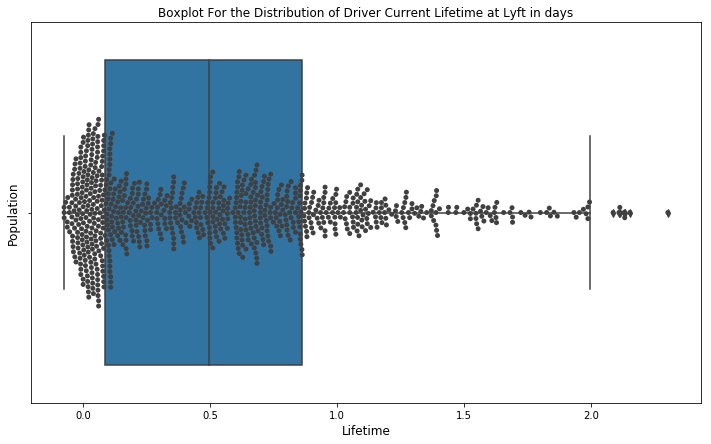

In [621]:
fig = plt.figure(figsize=(12, 7))
sns.boxplot(np.log(big_drivers_info['Lifetime']))
sns.swarmplot(np.log(big_drivers_info['Lifetime']), color=".25")
plt.xlabel('Lifetime', fontsize = 12)
plt.ylabel('Population', fontsize = 12)
plt.title('Boxplot For the Distribution of Driver Current Lifetime at Lyft in days', fontsize = 12)
#fig.savefig('Boxplot Distribution of Driver Lifetime.jpg',dpi=300)

## Question 3: Do all drivers act alike? Are there specific segments of drivers that generate more value for Lyft than the average driver? (Work in Progress)

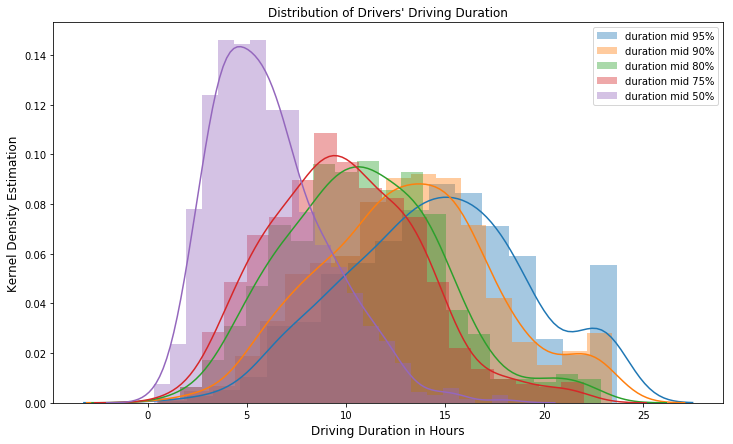

In [488]:
fig = plt.figure(figsize=(12, 7))
ax = sns.distplot(percentile[['duration mid 95%']])
sns.distplot(percentile['duration mid 90%'])
sns.distplot(percentile['duration mid 80%'])
sns.distplot(percentile['duration mid 75%'])
sns.distplot(percentile['duration mid 50%'])
plt.legend(['duration mid 95%','duration mid 90%','duration mid 80%','duration mid 75%','duration mid 50%'])
plt.title('Distribution of Drivers\' Driving Duration', fontsize = 12)
plt.xlabel('Driving Duration in Hours', fontsize = 12)
plt.ylabel('Kernel Density Estimation', fontsize = 12)
fig.savefig('Distribution of Driving Duration.jpg',dpi=300)

In [818]:
df = ride_timestamps_df[ride_timestamps_df.event == 'accepted_at']
df = pd.merge(df, ride_df, left_on = 'ride_id', right_on = 'ride_id')
df['time'] = df.timestamp.apply(lambda x: (x.hour*3600+x.minute*60+x.second)/3600)
df['time'] = df.time.astype('float')

In [839]:
np.random.seed(0)
choice = np.random.choice(df['driver_id'].unique(), 20)
subset = df[df['driver_id'].apply(lambda x: x in choice)]

In [842]:
subset['time'] = subset['time'].apply(lambda x: x+24 if x<6 else x)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


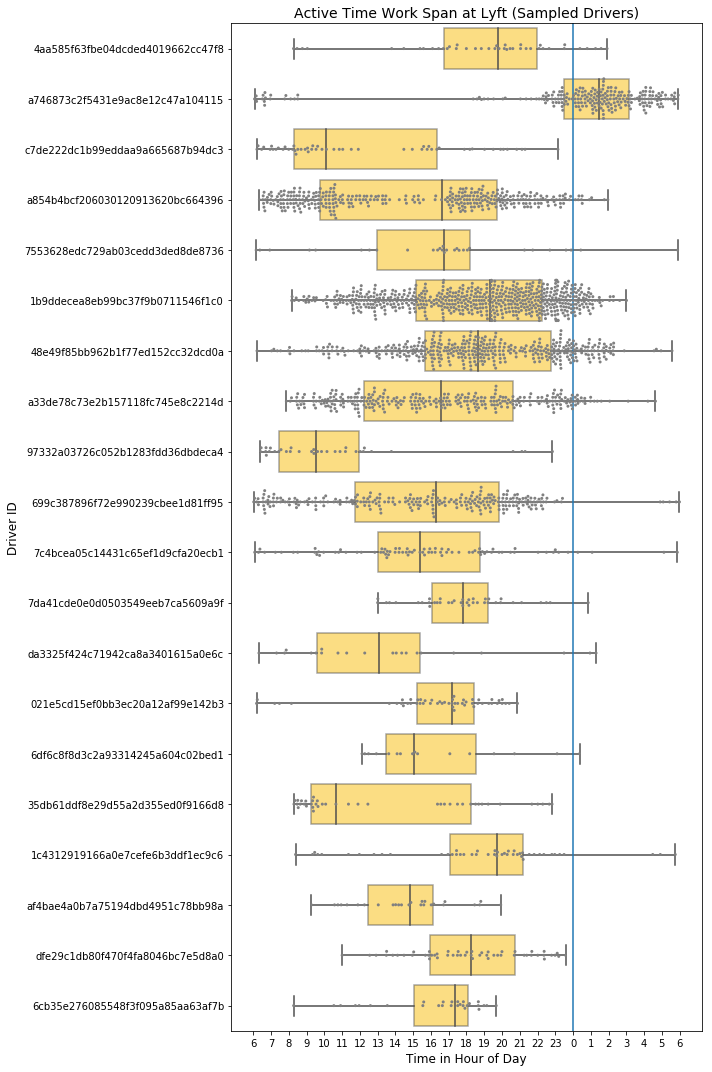

In [852]:
fig = plt.figure(figsize = (10, 15))
sns.swarmplot(y = 'driver_id', x = 'time', data = subset, orient = 'h',color=".5", size = 3)
ax = sns.boxplot(y = 'driver_id', x = 'time', data = subset, whis = 'range', orient = 'h', color = sns.xkcd_rgb['golden rod'], saturation = 1, boxprops = dict(alpha = 0.5))

plt.xlabel('Time in Hour of Day', fontsize = 12)
plt.ylabel('Driver ID', fontsize = 12)
plt.title('Active Time Work Span at Lyft (Sampled Drivers)', fontsize = 14)
ax.set_xticks(np.arange(6, 31))
ax.set_xticklabels(np.arange(6, 31)%24)
ax.axvline(24)
plt.tight_layout()
fig.savefig('Boxplot all Drivers\' work hours.jpg',dpi=300)


In [622]:
## Night time worker:
## Definition: Workers whose 2.5% ride and 97.5% ride are at least 15 hours apart
## while the 25% and 75% ride are at least 8 hours apart
night = percentile[(percentile['2.5%'] + 24 - percentile['97.5%'] <= 4) & (percentile['duration mid 95%'] >= 15) & (percentile['duration mid 50%'] >= 8)].index
percentile[(percentile['2.5%'] + 24 - percentile['97.5%'] <= 4) &(percentile['duration mid 95%'] >= 15) & (percentile['duration mid 50%'] >= 8)].head()

,mean,std,min,2.5%,5%,10%,12.5%,25%,50%,75%,87.5%,90%,95%,97.5%,max,duration mid 95%,duration mid 90%,duration mid 80%,duration mid 75%,duration mid 50%
driver_id,,,,,,,,,,,,,,,,,,,,
db63522a6a88af9b817df48e3f6bad15,16.656044,6.320282,6.059722,6.745861,7.163917,7.979500,8.259792,9.788056,18.435417,21.771597,23.498889,23.934722,25.262389,26.759958,29.939444,20.014097,18.098472,15.955222,15.239097,11.983542
40061a1bbba0ff209c889094d24f6032,15.408049,6.158291,6.539444,7.323278,7.676611,8.244556,8.458333,9.889722,14.419167,20.568611,24.127778,24.915778,26.291889,27.342500,29.537222,20.019222,18.615278,16.671222,15.669444,10.678889
d967f5296732fa55266b5f1314e7447b,18.118199,5.977740,6.089167,7.154750,7.980500,8.825667,9.238056,12.330278,20.007778,22.577500,23.808056,24.063278,25.691944,27.175472,29.920278,20.020722,17.711444,15.237611,14.570000,10.247222
f4b761ebd4f310f03e5e7f79b925ef4f,15.768806,5.569540,6.029444,6.608597,7.264736,8.024167,8.445104,10.712153,16.575556,19.177083,22.220694,22.896389,24.846681,26.721472,29.946944,20.112875,17.581944,14.872222,13.775590,8.464931
bd9366761825d97d4c79c2c61638318b,15.924892,5.825048,6.133611,6.622556,7.035833,7.862667,8.081319,10.465556,16.752500,19.947917,22.633542,23.112333,25.521778,26.785319,29.572778,20.162764,18.485944,15.249667,14.552222,9.482361


In [623]:
# Label the drivers into day and night
big_drivers_info['Work_Period'] = 'Day'
big_drivers_info['Work_Period'].loc[night] = 'Night'

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [862]:
# Construct log scaled shift-period labeled new dataframe that has the same length of 
temp = big_drivers_info.copy()
temp['Lifetime Value'] = np.log(temp['Lifetime Value'])
temp['Lifetime'] = np.log(temp['Lifetime'])
np.random.seed(1)
select = np.random.choice(temp.loc[set(temp.index) - set(night)].index, len(night))
new_df = temp.loc[select].append(temp.loc[night])

Text(0.5, 1.0, 'Boxplot For the Comparison on Driver Projected Lifetime at Lyft')

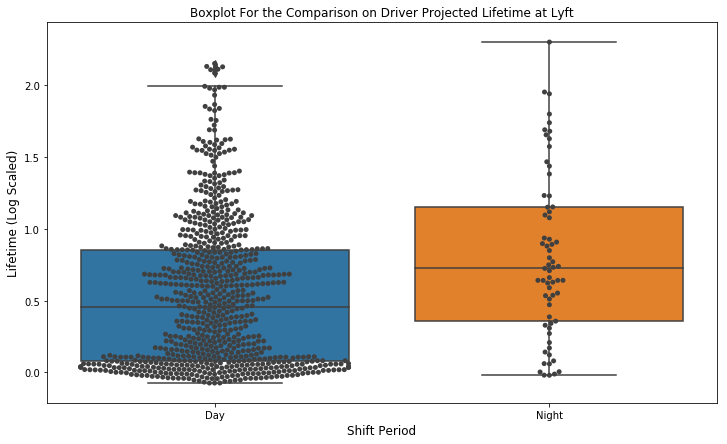

In [863]:
fig = plt.figure(figsize=(12, 7))
sns.boxplot(x = 'Work_Period', y = 'Lifetime', data = temp)
sns.swarmplot(x = 'Work_Period', y = 'Lifetime', data = temp, color=".25")
plt.xlabel('Shift Period', fontsize = 12)
plt.ylabel('Lifetime (Log Scaled)', fontsize = 12)
plt.title('Boxplot For the Comparison on Driver Projected Lifetime at Lyft', fontsize = 12)
#fig.savefig('Boxplot Comparison of Driver Projected Lifetime on shift period.jpg',dpi=300)


Text(0.5, 1.0, 'Boxplot For the Comparison on Driver Projected Lifetime at Lyft (Random Sampled Day Worker)')

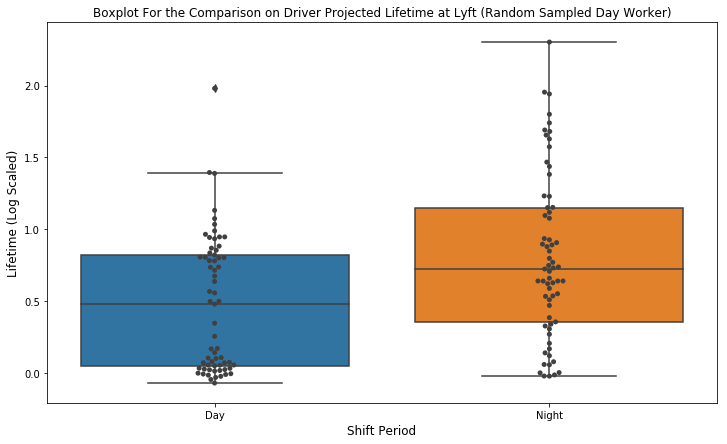

In [864]:
fig = plt.figure(figsize=(12, 7))
sns.boxplot(x = 'Work_Period', y = 'Lifetime', data = new_df)
sns.swarmplot(x = 'Work_Period', y = 'Lifetime', data = new_df, color=".25")
plt.xlabel('Shift Period', fontsize = 12)
plt.ylabel('Lifetime (Log Scaled)', fontsize = 12)
plt.title('Boxplot For the Comparison on Driver Projected Lifetime at Lyft (Random Sampled Day Worker)', fontsize = 12)
#fig.savefig('Boxplot Comparison of Driver Projected Lifetime on shift period(sampled).jpg',dpi=300)


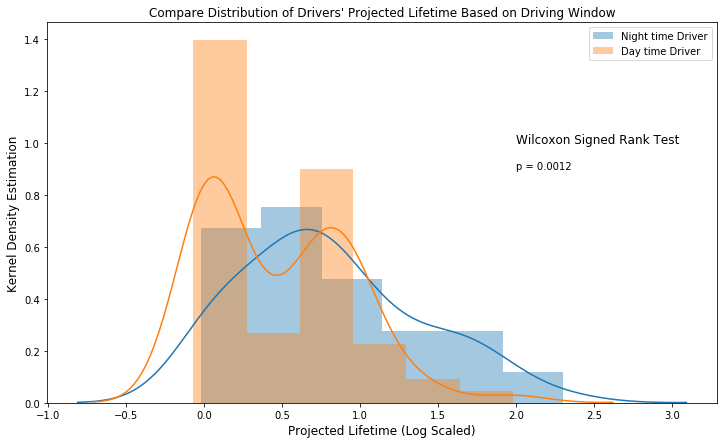

In [678]:
np.random.seed(1)
fig = plt.figure(figsize=(12, 7))
sns.distplot(temp.loc[night]['Lifetime'])
# Random select the same amount of drivers and compare distribution of lifetime value
sns.distplot(temp.loc[select]['Lifetime'])
plt.legend(['Night time Driver', 'Day time Driver'])
plt.title('Compare Distribution of Drivers\' Projected Lifetime Based on Driving Window', fontsize = 12)
plt.xlabel('Projected Lifetime (Log Scaled)', fontsize = 12)
plt.ylabel('Kernel Density Estimation', fontsize = 12)
plt.text(2, 1, "Wilcoxon Signed Rank Test", fontsize = 12)
plt.text(2, 0.9, "p = {}".format(round(stats.wilcoxon(temp.loc[select]['Lifetime'], temp.loc[night]['Lifetime']).pvalue,4), fontsize = 14))
#fig.savefig('Distribution of Projected Lifetime (based on driving time).jpg',dpi=300)

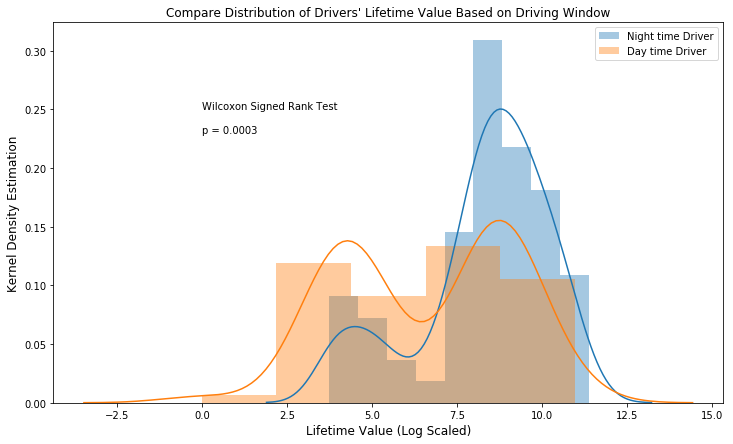

In [679]:
np.random.seed(1)
fig = plt.figure(figsize=(12, 7))
sns.distplot(temp.loc[night]['Lifetime Value'])
# Random select the same amount of drivers and compare distribution of lifetime value
sns.distplot(temp.loc[select]['Lifetime Value'])
plt.legend(['Night time Driver', 'Day time Driver'])
plt.title('Compare Distribution of Drivers\' Lifetime Value Based on Driving Window', fontsize = 12)
plt.xlabel('Lifetime Value (Log Scaled)', fontsize = 12)
plt.ylabel('Kernel Density Estimation', fontsize = 12)
plt.text(0, 0.25, "Wilcoxon Signed Rank Test")
plt.text(0, 0.23, "p = {}".format(np.round(stats.wilcoxon(temp.loc[select]['Lifetime Value'], temp.loc[night]['Lifetime Value']).pvalue, 4), fontsize = 12))
#fig.savefig('Distribution of Lifetime Value (based on driving time).jpg',dpi=300)

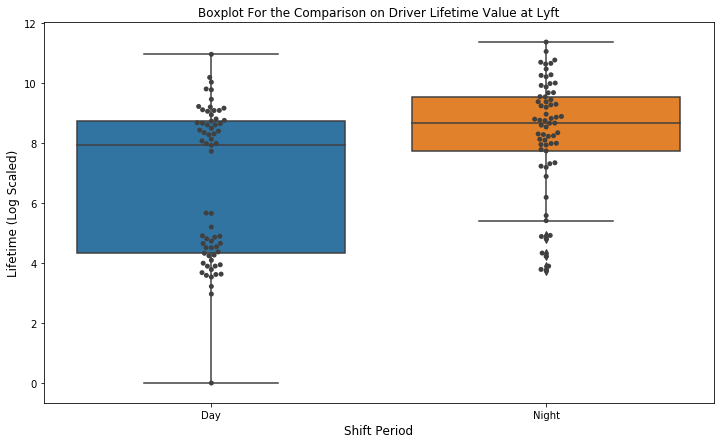

In [853]:
fig = plt.figure(figsize=(12, 7))
np.random.seed(1)
sns.boxplot(x = 'Work_Period', y = 'Lifetime Value', data = new_df)
sns.swarmplot(x = 'Work_Period', y = 'Lifetime Value', data = new_df, color=".25")
plt.xlabel('Shift Period', fontsize = 12)
plt.ylabel('Lifetime (Log Scaled)', fontsize = 12)
plt.title('Boxplot For the Comparison on Driver Lifetime Value at Lyft', fontsize = 12)
#fig.savefig('Boxplot Comparison of Driver Lifetime Value on shift period.jpg',dpi=300)

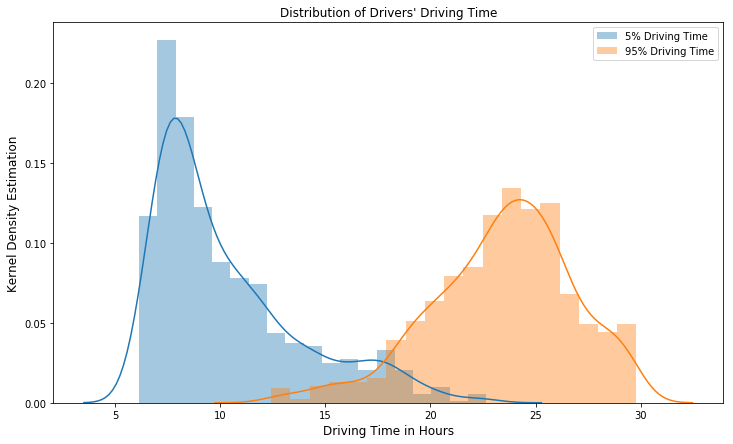

In [489]:
fig = plt.figure(figsize=(12, 7))
sns.distplot(percentile['5%'])
sns.distplot(percentile['95%'])
plt.legend(['5% Driving Time', '95% Driving Time'])
plt.title('Distribution of Drivers\' Driving Time', fontsize = 12)
plt.xlabel('Driving Time in Hours', fontsize = 12)
plt.ylabel('Kernel Density Estimation', fontsize = 12)
fig.savefig('Distribution of Driving Time.jpg',dpi=300)

In [879]:
big_drivers_info['Lifetime Value'].describe()

count      837.000000
mean      6432.043133
std      11105.510886
min          0.861601
25%        122.575112
50%       2722.030331
75%       7460.677400
max      85923.339816
Name: Lifetime Value, dtype: float64

In [880]:
big_drivers_info['Value'] = 'Low'
big_drivers_info.loc[big_drivers_info['Lifetime Value'] >= np.percentile(big_drivers_info['Lifetime Value'], 25), 'Value'] = 'Medium'
big_drivers_info.loc[big_drivers_info['Lifetime Value'] >= np.percentile(big_drivers_info['Lifetime Value'], 75), 'Value'] = 'High'


In [881]:
big_drivers_info.Value.value_counts()

Medium    418
High      210
Low       209
Name: Value, dtype: int64

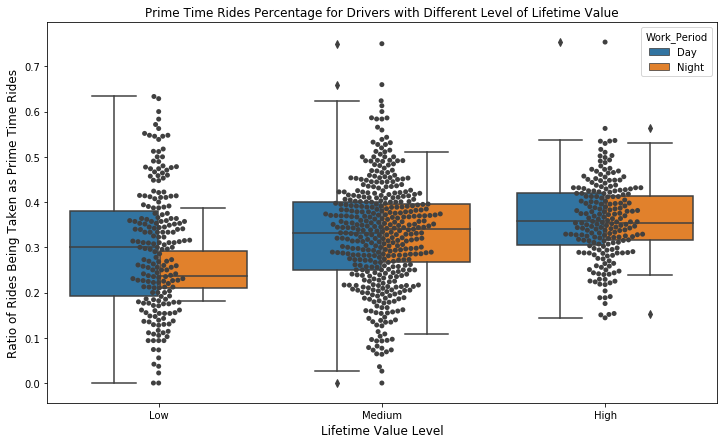

In [899]:
fig = plt.figure(figsize=(12, 7))
sns.boxplot(x = 'Value', y = 'prime time rides percentage', hue = 'Work_Period', data = big_drivers_info, order = ['Low','Medium','High'])
sns.swarmplot(x = 'Value', y = 'prime time rides percentage', data = big_drivers_info, order = ['Low','Medium','High'],color=".25")
plt.xlabel('Lifetime Value Level', fontsize = 12)
plt.ylabel('Ratio of Rides Being Taken as Prime Time Rides', fontsize = 12)
plt.title('Prime Time Rides Percentage for Drivers with Different Level of Lifetime Value', fontsize = 12)
#fig.savefig('Boxplot Comparison for Prime Time Rides Percentage.jpg',dpi=300)

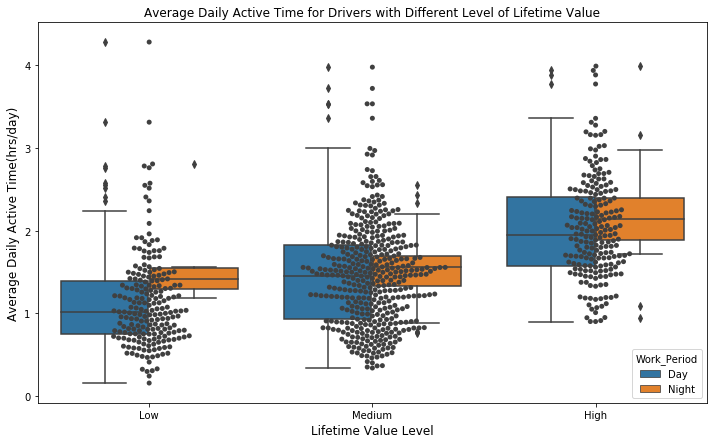

In [901]:
fig = plt.figure(figsize=(12, 7))
sns.boxplot(x = 'Value', y = 'average daily active time(hrs/day)', hue = 'Work_Period', data = big_drivers_info, order = ['Low','Medium','High'])
sns.swarmplot(x = 'Value', y = 'average daily active time(hrs/day)', data = big_drivers_info, order = ['Low','Medium','High'],color=".25")
plt.xlabel('Lifetime Value Level', fontsize = 12)
plt.ylabel('Average Daily Active Time(hrs/day)', fontsize = 12)
plt.title('Average Daily Active Time for Drivers with Different Level of Lifetime Value', fontsize = 12)
#fig.savefig('Boxplot Comparison for Average Daily Active Time.jpg',dpi=300)

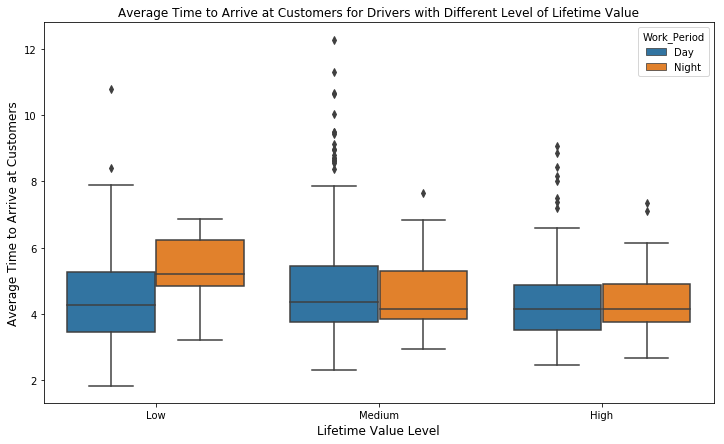

In [904]:
fig = plt.figure(figsize=(12, 7))
np.random.seed(1)
sns.boxplot(x = 'Value', y = 'average arriving time(minutes)', hue = 'Work_Period',data = big_drivers_info, order = ['Low','Medium','High'])
#sns.swarmplot(x = 'Value', y = 'average arriving time(minutes)', data = big_drivers_info, order = ['Low','Medium','High'], color=".25")
plt.xlabel('Lifetime Value Level', fontsize = 12)
plt.ylabel('Average Time to Arrive at Customers', fontsize = 12)
plt.title('Average Time to Arrive at Customers for Drivers with Different Level of Lifetime Value', fontsize = 12)
#fig.savefig('Boxplot Comparison for Average Time to Arrive at Customers.jpg',dpi=300)

In [925]:
big_rides_info = pd.read_csv('added_variables_rides_info.csv', parse_dates = ['driver_onboard_date', 'requested_at','accepted_at',
                                                                             'arrived_at','picked_up_at','dropped_off_at'])


In [928]:
big_drivers_info['Average Speed'] = big_rides_info.groupby('driver_id')['speed(m/s)'].mean()

In [ ]:
big_drivers_info['Average Single Ride Duration'] = big_rides_info.groupby('driver_id')['ride_duration'].mean()
big_drivers_info['Average Single Ride Distance'] = big_rides_info.groupby('driver_id')['ride_dist'].mean()


In [932]:
big_rides_info

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,speed(m/s),holiday,weekend,time of day,season,time spent to arrive at the customer(minutes),fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,2016-03-29,2016-04-23 02:13:50,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:16:40,2016-04-23 02:22:07,5.538226,0,1,4,0,2.766667,9.360365
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,2016-03-29,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:04:01,2016-03-29 19:17:30,4.155748,0,0,3,0,3.133333,9.113439
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,2016-03-29,2016-06-21 11:56:31,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:01:35,2016-06-21 12:11:07,5.737762,0,0,1,1,5.016667,8.187399
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,2016-03-29,2016-05-19 09:15:29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 09:18:20,2016-05-19 10:13:58,19.557519,0,0,1,0,2.850000,78.170140
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,2016-03-29,2016-04-20 22:05:30,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:07:02,2016-04-20 22:20:45,5.000000,0,0,3,0,1.550000,19.403323
5,002be0ffdc997bd5c50703158b7c2491,03d6b9d80b8a96135cb9b25178e9e203,4832,917,100,2016-03-29,2016-06-21 08:29:17,2016-06-21 08:29:24,2016-06-21 08:35:33,2016-06-21 08:35:36,2016-06-21 08:50:53,5.269357,0,0,0,1,6.266667,21.115099
6,002be0ffdc997bd5c50703158b7c2491,04053c0ed21761e07f0b869cab5b7dd0,1575,347,0,2016-03-29,2016-04-16 22:28:05,2016-04-16 22:28:08,2016-04-16 22:29:10,2016-04-16 22:29:15,2016-04-16 22:35:02,4.538905,0,1,3,0,1.083333,6.145308
7,002be0ffdc997bd5c50703158b7c2491,0534d432e0186625f623aaee57af98be,3056,687,25,2016-03-29,2016-04-01 21:53:09,2016-04-01 21:53:12,2016-04-01 21:54:15,2016-04-01 21:54:14,2016-04-01 22:05:41,4.448326,0,0,3,0,1.100000,10.559910
8,002be0ffdc997bd5c50703158b7c2491,053a1621c0affcd2b9c517af5c2bc843,3940,1143,75,2016-03-29,2016-05-25 16:26:32,2016-05-25 16:27:03,2016-05-25 16:38:20,2016-05-25 16:38:22,2016-05-25 16:57:25,3.447069,0,0,2,0,11.800000,18.812885
9,002be0ffdc997bd5c50703158b7c2491,066e92c52f59486de56cd7b8716a4ca6,3957,868,50,2016-03-29,2016-06-10 09:20:16,2016-06-10 09:20:19,2016-06-10 09:27:12,2016-06-10 09:27:14,2016-06-10 09:41:42,4.558756,0,0,1,1,6.933333,14.631011


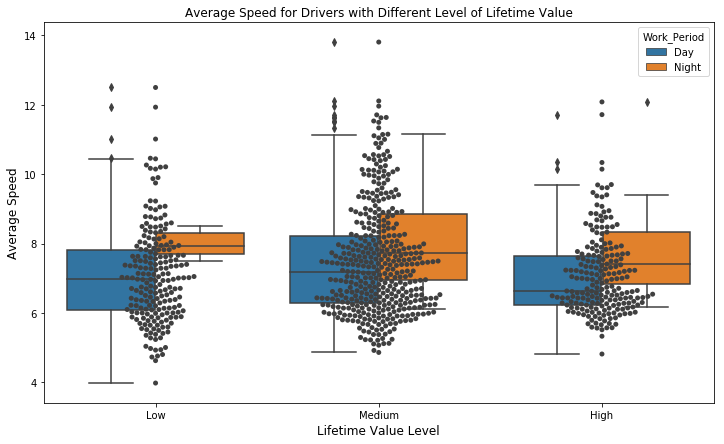

In [930]:
fig = plt.figure(figsize=(12, 7))
sns.boxplot(x = 'Value', y = 'Average Speed', hue = 'Work_Period', data = big_drivers_info, order = ['Low','Medium','High'])
sns.swarmplot(x = 'Value', y = 'Average Speed', data = big_drivers_info, order = ['Low','Medium','High'],color=".25")
plt.xlabel('Lifetime Value Level', fontsize = 12)
plt.ylabel('Average Speed', fontsize = 12)
plt.title('Average Speed for Drivers with Different Level of Lifetime Value', fontsize = 12)
#fig.savefig('Boxplot Comparison for Average Speed.jpg',dpi=300)

## Question 2 : What is the average projected lifetime of a driver? That is, once a driver is onboarded, how long do they typically continue driving with Lyft?

In [855]:
print("The average projected lifetime of a driver is {} years".format(np.round(np.mean(big_drivers_info['Lifetime']),2)))

The average projected lifetime of a driver is 2.02 years


In [861]:
big_drivers_info['Lifetime'].describe()

count    837.000000
mean       2.022258
std        1.323135
min        0.927835
25%        1.090426
50%        1.641791
75%        2.368421
max       10.000000
Name: Lifetime, dtype: float64

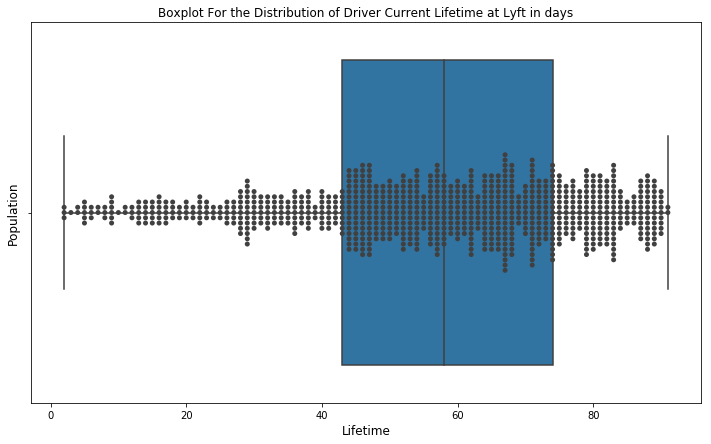

In [363]:
fig = plt.figure(figsize=(12, 7))
sns.boxplot(big_drivers_info['Lifetime'])
sns.swarmplot(big_drivers_info['Lifetime'], color=".25")
plt.xlabel('Lifetime', fontsize = 12)
plt.ylabel('Population', fontsize = 12)
plt.title('Boxplot For the Distribution of Driver Current Lifetime at Lyft in days', fontsize = 12)
fig.savefig('Boxplot Distribution of Current Driver Lifetime.jpg',dpi=300)

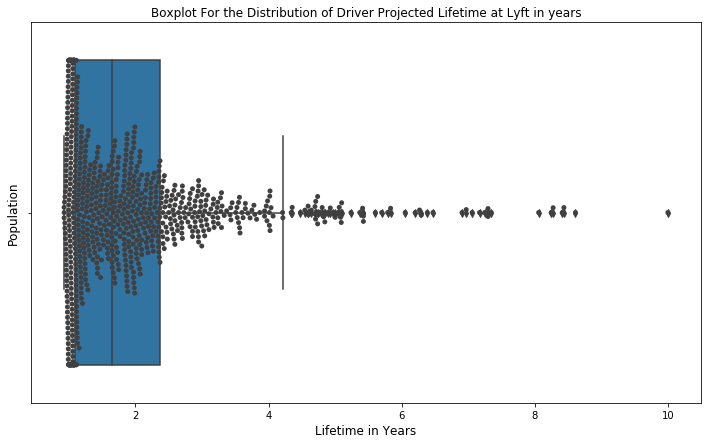

In [860]:
fig = plt.figure(figsize=(12, 7))
sns.boxplot(big_drivers_info['Lifetime'])
sns.swarmplot(big_drivers_info['Lifetime'], color=".25")
plt.xlabel('Lifetime in Years', fontsize = 12)
plt.ylabel('Population', fontsize = 12)
plt.title('Boxplot For the Distribution of Driver Projected Lifetime at Lyft in years', fontsize = 12)
#fig.savefig('Boxplot Distribution of projected Driver Lifetime.jpg',dpi=300)

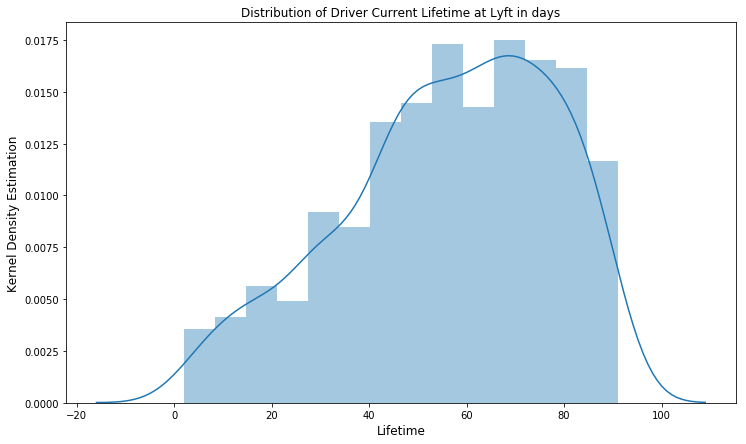

In [362]:
fig = plt.figure(figsize=(12, 7))
sns.distplot(big_drivers_info['Lifetime'])
plt.title('Distribution of Driver Current Lifetime at Lyft in days', fontsize = 12)
plt.xlabel('Lifetime', fontsize = 12)
plt.ylabel('Kernel Density Estimation', fontsize = 12)
fig.savefig('Distribution of Current Driver Lifetime.jpg',dpi=300)

## EDA (Work in Progress)

In [288]:
big_drivers_info.sort_values('Lifetime Value')#.to_csv('temp.csv')

,prime time rides percentage,average daily active time(hrs/day),gross fare(over all rides),average daily fare,average fare per ride,average monthly fare,total rides,number of abnormal rides,completion rate,active days,average arriving time(minutes),last_ride,driver_onboard_date,total days with Lyft,Retention Rate,Lifetime Value
driver_id,,,,,,,,,,,,,,,,
7b625f643d0775f0ac4898e33235377b,0.000000,0.158519,25.675718,8.558573,8.558573,25.675718,3,0,1.000000,3,4.805556,2016-04-19,2016-04-04,84,0.035714,0.861601
7ff85c5c0e9324e28d1e0d0589c364bd,0.333333,0.243194,36.465840,18.232920,12.155280,18.232920,3,0,1.000000,2,3.427778,2016-06-22,2016-04-19,69,0.028986,0.986897
bd057e02f75c92917389d90bb215fe91,0.037037,2.549028,258.889593,129.444796,9.588503,258.889593,27,0,1.000000,2,3.195679,2016-03-30,2016-03-29,90,0.022222,5.337930
68b546b2f4102641d6774c1ce4f57457,0.227273,2.782778,259.197641,129.598821,11.781711,259.197641,22,0,1.000000,2,2.390152,2016-03-31,2016-03-30,89,0.022472,5.405582
6eb2e0f41fc9f1fbb70e7751035fdf87,0.142857,4.281667,424.063439,212.031719,12.116098,424.063439,35,0,1.000000,2,4.470000,2016-03-30,2016-03-29,90,0.022222,8.743576
a2334fdb829cf96fbae920df0cce1587,0.480000,1.890185,299.911874,99.970625,11.996475,299.911874,25,0,1.000000,3,3.476000,2016-04-10,2016-04-08,80,0.037500,10.585125
e4f3a9d5cf57b9b518136afd9757f76d,0.093750,1.461181,286.415232,71.603808,8.950476,286.415232,32,0,1.000000,4,2.898958,2016-03-31,2016-03-28,91,0.043956,11.921550
706466935b9e1d04e4e116be7ce90ea9,0.210526,0.810111,224.590397,44.918079,11.820547,112.295198,19,0,1.000000,5,6.531579,2016-05-14,2016-04-01,87,0.057471,12.380948
da3325f424c71942ca8a3401615a0e6c,0.136364,0.937167,239.364646,47.872929,10.880211,119.682323,22,0,1.000000,5,4.546970,2016-05-29,2016-04-04,84,0.059524,13.693630


In [272]:
big_rides_info.requested_at.apply(lambda x: x.month).value_counts()

5    78842
6    67146
4    36997
3     1224
Name: requested_at, dtype: int64

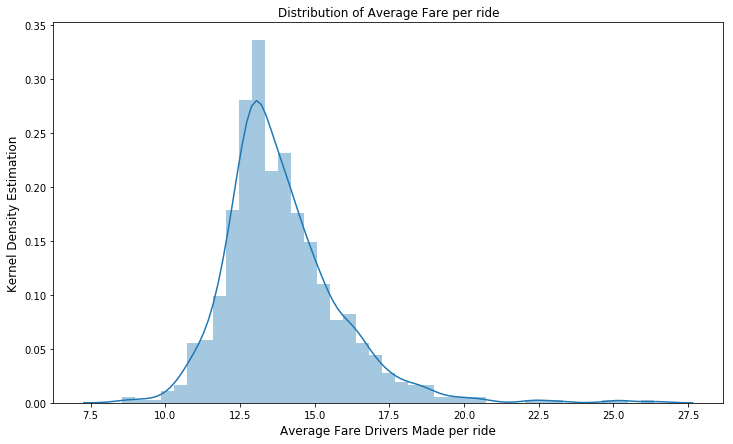

In [245]:
fig = plt.figure(figsize=(12, 7))
sns.distplot(big_drivers_info['average fare per ride'])
plt.title('Distribution of Average Fare per ride', fontsize = 12)
plt.xlabel('Average Fare Drivers Made per ride', fontsize = 12)
plt.ylabel('Kernel Density Estimation', fontsize = 12)
fig.savefig('Average Fare per ride.jpg',dpi=300)

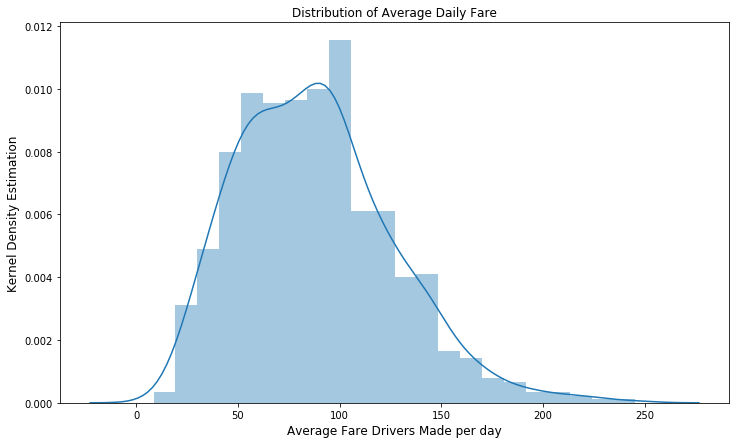

In [246]:
fig = plt.figure(figsize=(12, 7))
sns.distplot(big_drivers_info['average daily fare'])
plt.title('Distribution of Average Daily Fare', fontsize = 12)
plt.xlabel('Average Fare Drivers Made per day', fontsize = 12)
plt.ylabel('Kernel Density Estimation', fontsize = 12)
fig.savefig('Average Daily Fare.jpg',dpi=300)

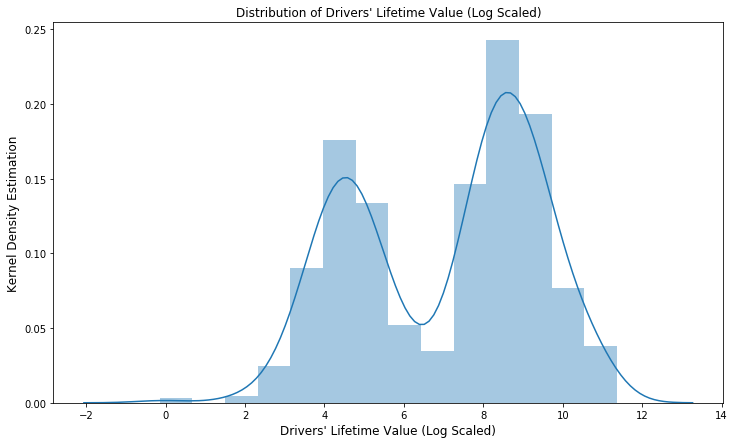

In [297]:
fig = plt.figure(figsize=(12, 7))
sns.distplot(np.log(big_drivers_info['Lifetime Value']))
plt.title('Distribution of Drivers\' Lifetime Value (Log Scaled)', fontsize = 12)
plt.xlabel('Drivers\' Lifetime Value (Log Scaled)', fontsize = 12)
plt.ylabel('Kernel Density Estimation', fontsize = 12)
fig.savefig('Drivers Lifetime Value.jpg',dpi=300)

# Question 1 and 2.a
main factors that affect a driver's lifetime value

In [30]:
import statsmodels.api as sm
from sklearn.linear_model import LassoCV, RidgeCV

In [6]:
print(big_drivers_info.shape)
display(big_drivers_info.head())

(837, 17)


,prime time rides percentage,average daily active time(hrs/day),gross fare(over all rides),average daily fare,average fare per ride,average monthly fare,total rides,number of abnormal rides,completion rate,active days,average arriving time(minutes),last_ride,driver_onboard_date,total days with Lyft,Retention Rate,Lifetime Value,Lifetime
driver_id,,,,,,,,,,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,0.397112,1.097411,3651.957780,65.213532,13.183963,912.989445,277,0,1.0,56,3.023285,2016-06-23,2016-03-29,90,0.622222,4756.038040,87
007f0389f9c7b03ef97098422f902e62,0.387097,0.474468,332.355469,27.696289,10.721144,83.088867,31,0,1.0,12,3.150000,2016-06-22,2016-03-29,90,0.133333,45.842134,86
011e5c5dfc5c2c92501b8b24d47509bc,0.470588,0.676042,493.765123,41.147094,14.522504,164.588374,34,0,1.0,12,3.842157,2016-06-12,2016-04-05,83,0.144578,74.718556,69
0152a2f305e71d26cc964f8d4411add9,0.251309,1.211951,2644.233047,66.105826,13.844152,881.411016,191,0,1.0,40,4.145462,2016-06-26,2016-04-23,65,0.615385,3357.756250,65
01674381af7edd264113d4e6ed55ecda,0.264000,2.482243,5457.997548,136.449939,14.554660,1819.332516,375,0,1.0,40,3.816933,2016-06-24,2016-04-29,59,0.677966,8767.867546,57


In [7]:
model_drivers_feat = big_drivers_info.drop(columns=['last_ride','gross fare(over all rides)',\
                                                    'average daily fare','average fare per ride',\
                                                    'average monthly fare','driver_onboard_date',\
                                                    'active days','Retention Rate','total days with Lyft',\
                                                    'Lifetime'])
print(model_drivers_feat.shape)
display(model_drivers_feat.head())

(837, 7)


,prime time rides percentage,average daily active time(hrs/day),total rides,number of abnormal rides,completion rate,average arriving time(minutes),Lifetime Value
driver_id,,,,,,,
002be0ffdc997bd5c50703158b7c2491,0.397112,1.097411,277,0,1.0,3.023285,4756.038040
007f0389f9c7b03ef97098422f902e62,0.387097,0.474468,31,0,1.0,3.150000,45.842134
011e5c5dfc5c2c92501b8b24d47509bc,0.470588,0.676042,34,0,1.0,3.842157,74.718556
0152a2f305e71d26cc964f8d4411add9,0.251309,1.211951,191,0,1.0,4.145462,3357.756250
01674381af7edd264113d4e6ed55ecda,0.264000,2.482243,375,0,1.0,3.816933,8767.867546


In [8]:
# set random seed
np.random.seed(seed=42)
data = model_drivers_feat.values
# 80% as training+validation data
train_data_idx = np.random.choice(range(data.shape[0]),int(data.shape[0]*0.8),replace=False)
test_data_idx = np.array([x for x in range(data.shape[0]) if x not in train_data_idx])

In [9]:
# training(with validation) and testing data
train_X = data[train_data_idx][:,:-1]
train_Y = data[train_data_idx][:,-1]
test_X = data[test_data_idx][:,:-1]
test_Y = data[test_data_idx][:,-1]
train_X = np.apply_along_axis(lambda x: (x-np.mean(x))/np.std(x),0,train_X)
test_X = np.apply_along_axis(lambda x: (x-np.mean(x))/np.std(x),0,test_X)

## Lasso

In [10]:
lasso_clf = LassoCV(cv=10,random_state=42)
lasso_clf.fit(train_X,train_Y)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=42, selection='cyclic',
        tol=0.0001, verbose=False)

In [11]:
print(lasso_clf.coef_)
print(np.sort(np.abs(lasso_clf.coef_)))
print(np.argsort(np.abs(lasso_clf.coef_)))
print(model_drivers_feat.columns[np.argsort(np.abs(lasso_clf.coef_))[::-1]])

[   0.         -434.62037685 9122.85223683   66.97323112   -0.
  563.67865349]
[   0.            0.           66.97323112  434.62037685  563.67865349
 9122.85223683]
[0 4 3 1 5 2]
Index(['total rides', 'average arriving time(minutes)',
       'average daily active time(hrs/day)', 'number of abnormal rides',
       'completion rate', 'prime time rides percentage'],
      dtype='object')


In [12]:
lasso_clf.score(test_X,test_Y)

0.47466613601639746

## Ridge

In [13]:
ridge_clf = RidgeCV(cv=10,scoring='neg_mean_squared_error')
ridge_clf.fit(train_X,train_Y)

/Users/cyrusdeng/Documents/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=10, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring='neg_mean_squared_error',
        store_cv_values=False)

In [14]:
print(ridge_clf.coef_)
print(np.sort(np.abs(ridge_clf.coef_)))
print(np.argsort(np.abs(ridge_clf.coef_)))
print(model_drivers_feat.columns[np.argsort(np.abs(ridge_clf.coef_))[::-1]])

[  384.09592101 -1115.26348767  9623.96724014   530.85011633
   301.70818689   941.77652699]
[ 301.70818689  384.09592101  530.85011633  941.77652699 1115.26348767
 9623.96724014]
[4 0 3 5 1 2]
Index(['total rides', 'average daily active time(hrs/day)',
       'average arriving time(minutes)', 'number of abnormal rides',
       'prime time rides percentage', 'completion rate'],
      dtype='object')


In [15]:
ridge_clf.score(test_X,test_Y)

0.46804527643316823

## OLS

In [33]:
import patsy

In [34]:
model_drivers_feat.columns = ['prime_percentage','daily_active_time','rides','abnormal','completion','arriving','LifetimeValue']
model_drivers_feat.head()

,prime_percentage,daily_active_time,rides,abnormal,completion,arriving,LifetimeValue
driver_id,,,,,,,
002be0ffdc997bd5c50703158b7c2491,0.397112,1.097411,277,0,1.0,3.023285,4756.038040
007f0389f9c7b03ef97098422f902e62,0.387097,0.474468,31,0,1.0,3.150000,45.842134
011e5c5dfc5c2c92501b8b24d47509bc,0.470588,0.676042,34,0,1.0,3.842157,74.718556
0152a2f305e71d26cc964f8d4411add9,0.251309,1.211951,191,0,1.0,4.145462,3357.756250
01674381af7edd264113d4e6ed55ecda,0.264000,2.482243,375,0,1.0,3.816933,8767.867546


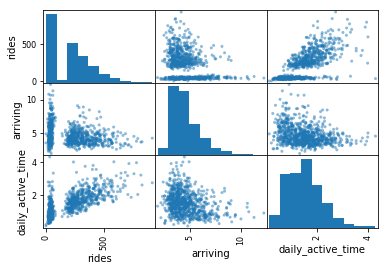

In [35]:
fd = pd.plotting.scatter_matrix(model_drivers_feat[['rides', 'arriving', 'daily_active_time']])

In [36]:
outcome_1, predictors_1 = patsy.dmatrices('LifetimeValue ~ rides + prime_percentage + daily_active_time + abnormal + completion + arriving', model_drivers_feat)
mod_all = sm.OLS(outcome_1, predictors_1)
res_all = mod_all.fit()
print(res_all.summary())

                            OLS Regression Results                            
Dep. Variable:          LifetimeValue   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     199.3
Date:                Sat, 14 Sep 2019   Prob (F-statistic):          4.57e-157
Time:                        15:01:09   Log-Likelihood:                -8610.5
No. Observations:                 837   AIC:                         1.724e+04
Df Residuals:                     830   BIC:                         1.727e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3.769e+04   3.98e+0